# K-Nearest Neighbors Modeling

In [36]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
#from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, roc_auc_score,\
recall_score, precision_score, average_precision_score, f1_score, classification_report,\
accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from alepython import ale_plot

## Read in the data

In [37]:
# read std data
df = pd.read_csv("hotel_bookings_dummy.csv")
df.head()

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,2,2015,7,0,0,0,3,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,2,2015,7,0,0,0,4,0,1,1,...,0,1,0,0,0,0,0,0,0,0
2,1,2015,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,2015,7,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,2,2015,7,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [38]:
# Number of features
df.shape

(119388, 43)

## Splitting train and test

In [39]:
# get train indexes
train_ind = pd.read_csv("train_index.csv")

# split train
train = df.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)

# Split test 
test = df.iloc[df.index.difference(train_ind.Train_Index),:]

In [40]:
train.head(3)

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,2,2017,4,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,2016,5,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,2,2017,8,1,1,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# Scale numeric columns 
scaler = StandardScaler()
scaler.fit(train.drop("is_canceled", axis = 1))

# Scale train data
xtrain = scaler.transform(train.drop("is_canceled", axis = 1))
ytrain = train.is_canceled

# Scale test data with train scaler 
xtest = scaler.transform(test.drop("is_canceled", axis = 1))
ytest = test.is_canceled

# Give everyone a header
dftrain = pd.DataFrame(xtrain)
dftrain.columns = train.drop("is_canceled", axis = 1).columns

In [42]:
dftrain.head(5)

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,0.255102,1.194999,-0.827079,-0.079146,0.397621,-0.246093,-0.339409,-0.259137,-0.827397,-2.645989,...,-0.214975,-0.343744,-0.445215,-0.506124,1.056154,-0.004576,-0.08367,2.698034,-0.313399,-0.098078
1,-1.514583,-0.220671,-0.503055,-0.079146,-2.514960,4.063508,-0.339409,-0.259137,1.208609,-2.645989,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
2,0.255102,1.194999,0.469018,10.108578,0.397621,-0.246093,1.200680,2.254616,-0.827397,0.377931,...,-0.214975,-0.343744,-0.445215,-0.506124,1.056154,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
3,0.255102,-0.220671,-0.503055,-0.079146,-2.514960,-0.246093,-0.339409,-0.259137,1.208609,0.377931,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
4,-1.514583,1.194999,-1.475128,-0.079146,-2.514960,-0.246093,-0.339409,-0.259137,1.208609,0.377931,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078


In [68]:
dftrain.describe()

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
count,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,...,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04,9.551100e+04
mean,-1.512583e-15,-1.222990e-13,-1.072538e-16,7.156610e-15,1.738468e-15,1.568913e-15,-1.814849e-15,-4.710198e-15,-3.147649e-16,-2.602643e-15,...,-5.376477e-15,-5.350455e-15,-3.210771e-15,-1.583449e-16,-2.646885e-16,1.315882e-15,-4.679429e-16,-1.143118e-15,4.939203e-16,1.370581e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.284267e+00,-1.636341e+00,-1.799152e+00,-7.914577e-02,-2.514960e+00,-2.460928e-01,-3.394094e-01,-2.591368e-01,-8.273974e-01,-2.645989e+00,...,-2.149752e-01,-3.437442e-01,-4.452146e-01,-5.061242e-01,-9.468313e-01,-4.576072e-03,-8.367048e-02,-3.706403e-01,-3.133990e-01,-9.807828e-02
25%,2.551016e-01,-2.206708e-01,-8.270793e-01,-7.914577e-02,3.976206e-01,-2.460928e-01,-3.394094e-01,-2.591368e-01,-8.273974e-01,3.779306e-01,...,-2.149752e-01,-3.437442e-01,-4.452146e-01,-5.061242e-01,-9.468313e-01,-4.576072e-03,-8.367048e-02,-3.706403e-01,-3.133990e-01,-9.807828e-02
50%,2.551016e-01,-2.206708e-01,1.449935e-01,-7.914577e-02,3.976206e-01,-2.460928e-01,-3.394094e-01,-2.591368e-01,-8.273974e-01,3.779306e-01,...,-2.149752e-01,-3.437442e-01,-4.452146e-01,-5.061242e-01,-9.468313e-01,-4.576072e-03,-8.367048e-02,-3.706403e-01,-3.133990e-01,-9.807828e-02
75%,2.551016e-01,1.194999e+00,7.930420e-01,-7.914577e-02,3.976206e-01,-2.460928e-01,-3.394094e-01,-2.591368e-01,1.208609e+00,3.779306e-01,...,-2.149752e-01,-3.437442e-01,-4.452146e-01,-5.061242e-01,1.056154e+00,-4.576072e-03,-8.367048e-02,-3.706403e-01,-3.133990e-01,-9.807828e-02
max,8.519995e+01,1.194999e+00,1.765115e+00,1.017981e+02,3.976206e-01,4.063508e+00,2.738219e+01,2.487839e+01,1.208609e+00,3.779306e-01,...,4.651699e+00,2.909140e+00,2.246108e+00,1.975800e+00,1.056154e+00,2.185280e+02,1.195165e+01,2.698034e+00,3.190821e+00,1.019594e+01


## Code to fit a K-NN Model using sklearn

In [43]:
# Define a function the does a grid search to find the best parameter that gives the best score
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    params = np.array(range(param_range[0],param_range[1]+1))
    #params = np.random.uniform(param_range[0],param_range[1],10)
    #params = np.array([int(i) for i in params])
    params = np.sort(params)
    # Reference link : https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f
    kf = KFold(n_splits=folds)

    x_train = pd.DataFrame(x_train)
    y_train = pd.DataFrame(y_train)

    TRAIN_SCORES = []
    TEST_SCORES  = [] 
    #TRAIN_F1 = []
    #TEST_F1 = []
    
    for p in params:

        training_scores = []
        crossval_scores = []
        #training_f1 = []
        #crossval_f1 = []
        classifier.n_neighbors = int(p)

        for i in range(folds):
            result = next(kf.split(x_train),None)
            x_training = x_train.iloc[result[0]]
            x_cv = x_train.iloc[result[1]]

            y_training = y_train.iloc[result[0]]
            y_cv = y_train.iloc[result[1]]

            model = classifier.fit(x_training,y_training)
            training_scores.append(model.score(x_training,y_training))
            crossval_scores.append(model.score(x_cv,y_cv))
            #training_f1.append(model.f1)
    
        TRAIN_SCORES.append(np.mean(training_scores))
        TEST_SCORES.append(np.mean(crossval_scores))
    
    return(TRAIN_SCORES , TEST_SCORES)

In [44]:
import warnings
warnings.filterwarnings('ignore')

## For k = 1-40

In [45]:
CV_score = []

In [92]:
# Use CV to find the K that optimizes accuracy
# It is too computationally intensive to do 10-fold validation, so I did 5.
classifier = KNeighborsClassifier()
X_train = pd.DataFrame(xtrain)
y_train = pd.DataFrame(ytrain)
train_score , cv_score = RandomSearchCV(X_train,y_train,classifier,(1,40),5)

print("The cross-validation accuracy is: ", cv_score)

The traning accuracy is:  [0.9936001465815097, 0.9251518165637107, 0.91989058737305, 0.9029290126688305, 0.8998665061250131, 0.8902863574494816, 0.8888205423515864, 0.8838995916657941, 0.8819364464453983, 0.8790440791540153, 0.8770809339336194, 0.8765966914459218, 0.8743194429902628, 0.8728405402575646, 0.8717804418385511, 0.8705763794367082, 0.8693723170348655, 0.8682075175374306, 0.8677101874149302, 0.8669249293267722, 0.8656816040205214, 0.8646869437755209, 0.8649748717411789, 0.8635352319128888, 0.8632603915820333, 0.8624620458590723, 0.8621479426238089, 0.8606428646215056, 0.8601193592294001, 0.8595565909328865, 0.8594126269500576, 0.8588629462883468, 0.858457229609465, 0.857554182808083, 0.8573971311904514, 0.8567165741807139, 0.8562061564234111, 0.8555386870484766, 0.854295361742226, 0.8538765574285415]
The cross-validation accuracy is:  [0.8502852955033241, 0.8521698162592262, 0.8542637282102288, 0.857875726325708, 0.8569334659477569, 0.8588703345024342, 0.8560435533685808, 0.8

The best k = 6

In [23]:
# Use CV to find the K that optimizes accuracy
# It is too computationally intensive to do 10-fold validation, so I did 5.
#classifier = KNeighborsClassifier()
X_train = pd.DataFrame(xtrain)
y_train = pd.DataFrame(ytrain)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd


# Create a range of values for k to test
k_range = range(1, 25)

# Create an empty list to store the cross-validation scores for each value of k
cv_scores = []

# Loop over the range of k values and perform 5-times replicated cross-validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

# Find the value of k with the highest cross-validation score
best_k = k_range[cv_scores.index(max(cv_scores))]
print("The best value of k is: ", best_k)

The best value of k is:  6


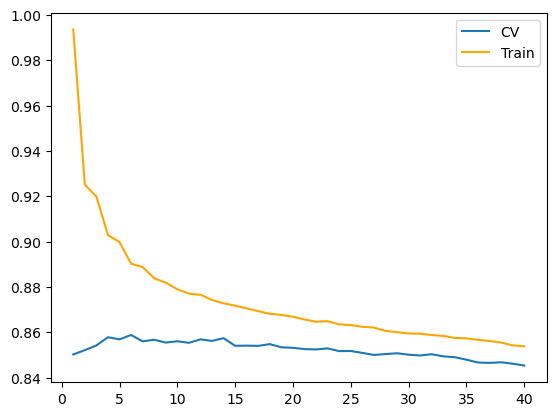

In [121]:
# Plot the accuracy score against K
plt.plot(cv_result['k'], cv_result['cv_score'], label = 'CV')
plt.plot(cv_result['k'], cv_result['train_score'], color = 'orange', label = 'Train')
plt.legend()
plt.show()

<AxesSubplot:xlabel='k'>

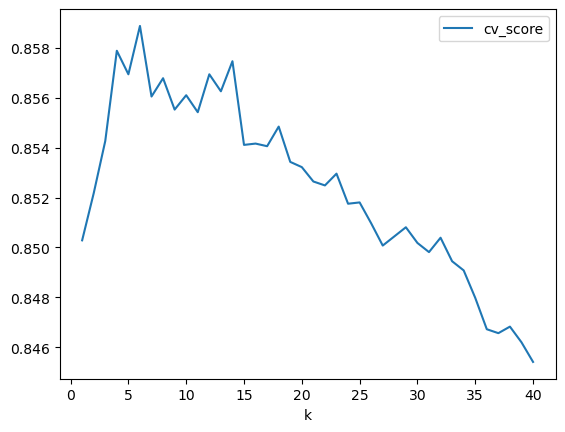

In [123]:
# Let's just look at the CV result
cv_result.plot(x = 'k', y = 'cv_score', kind = 'line')

The graph seems to suggest while the best accuracy is achieved at around k = 6, but seems like k = 14, or even k = 40 does fairly well.

In [18]:
# After I picked the best k, seems like I should fit the entire training

## Fitting the best model (K = 6)

In [20]:
# Get test accuracy
start = time.time()
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(xtrain, ytrain)
yhat_test = neigh.predict(xtest)
end = time.time()
time_fit = end - start
print('The computational time for KNN is', time_fit,'seconds')

The computational time for KNN is 3.637075901031494 seconds


In [23]:
# Get accuracy
knn_accuracy = accuracy_score(ytest, yhat_test)

print('The test accuracy for KNN is', knn_accuracy)

The test accuracy for KNN is 0.8614147505968086


In [24]:
# Get test F-1 Score
knn_f1 = f1_score(ytest, yhat_test)
print('The test F-1 score for KNN is', knn_f1)

The test F-1 score for KNN is 0.7998306212570321


In [25]:
# Get test AUC score
ROC_AUC = roc_auc_score(ytest, yhat_test)
print('The test ROC AUC score is: {:.4f}'.format(ROC_AUC))

The test ROC AUC score is: 0.8382


In [27]:
# Get test Confusion Matrix
cm = confusion_matrix(ytest, yhat_test)
cm

array([[13957,  1092],
       [ 2217,  6611]])

In [29]:
# Compute the misclassification rate
misclass_rate = (cm[0,1] + cm[1,0]) / sum(sum(cm))

print("The test Misclassification rate is ", misclass_rate, '.')

The test Misclassification rate is  0.13858524940319136 .


# Model Interpretation

Since KNN models don't have a built-in variable importance measure, and it doesn't have 
we assess the variable importance by observing the ALE plots;  
since ALE plot in Python only shows the graph for numerical predictros, we cannot include the categorical measures for KNN.

In [60]:
from alepython import ale_plot

In [70]:
num_cols = ['adults', 'arrival_date_year', 'arrival_month', 
            'babies', 'booking_changes', 'children', 'log_adr',
            'log_days_in_waiting_list', 'log_lead_time',
            'previous_bookings', 'previous_cancellations', 'total_nights',
            'total_of_special_requests']

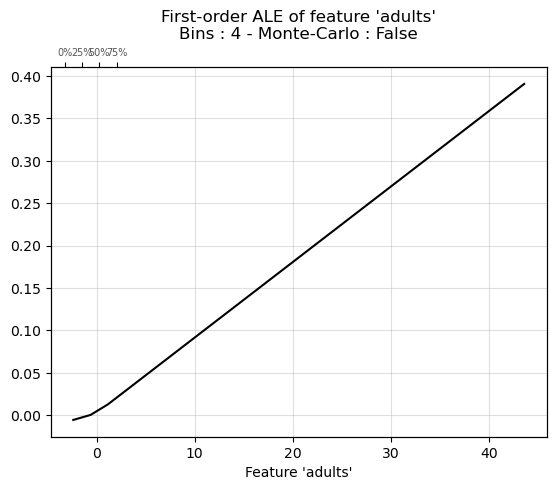

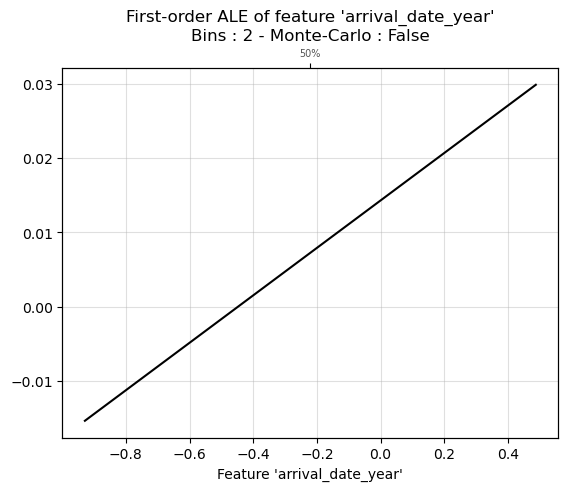

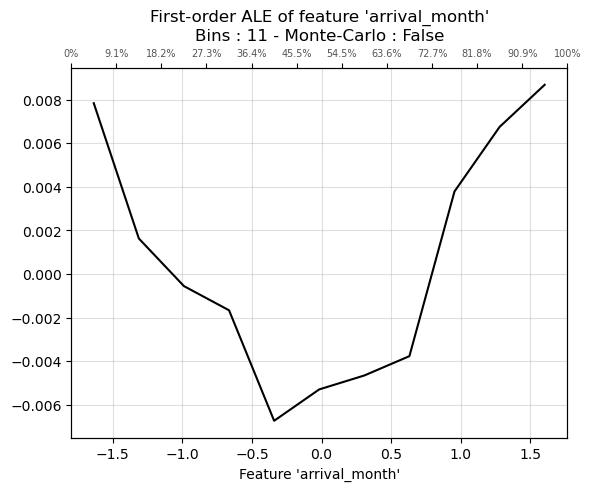

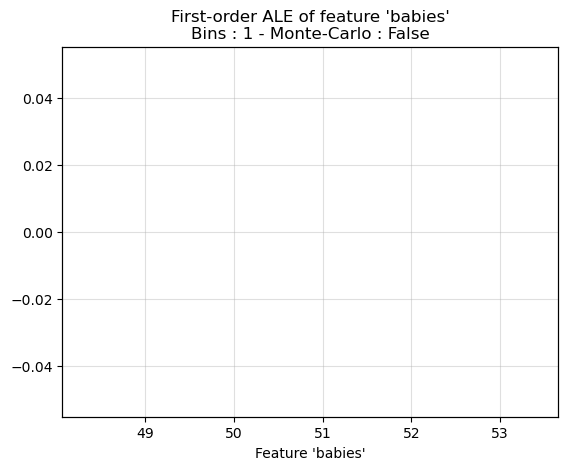

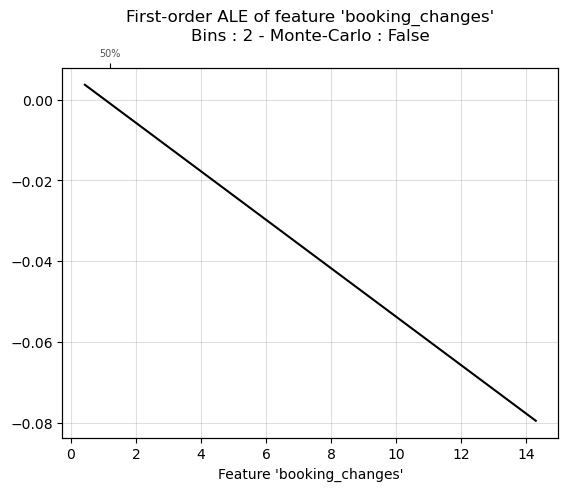

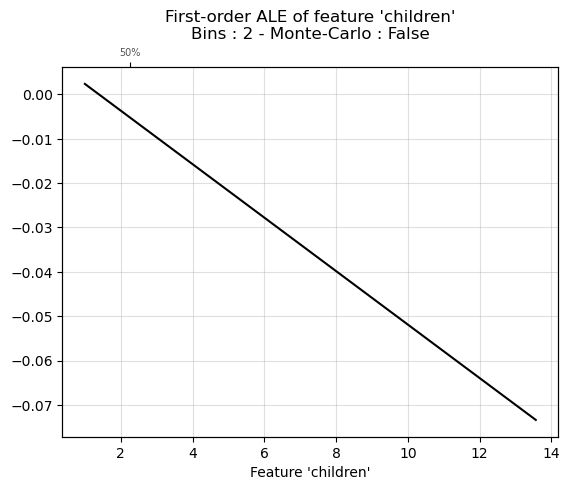

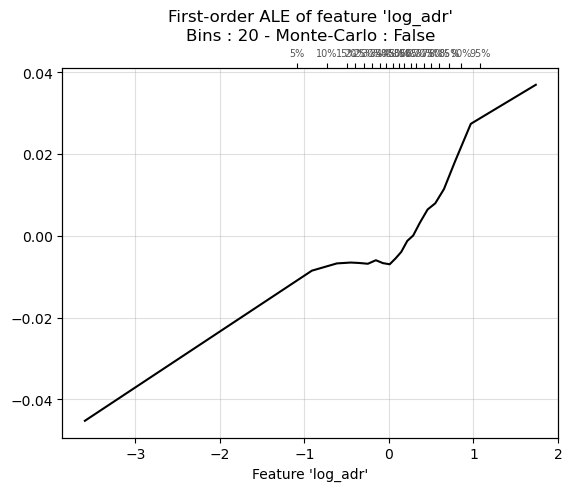

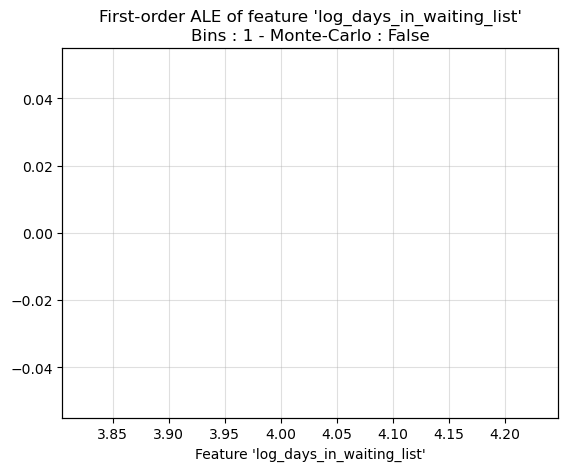

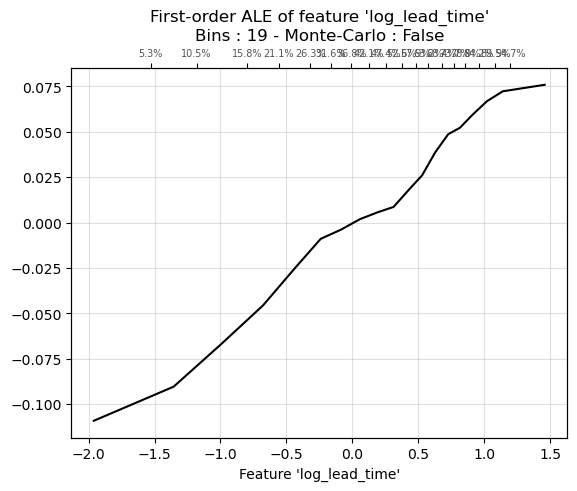

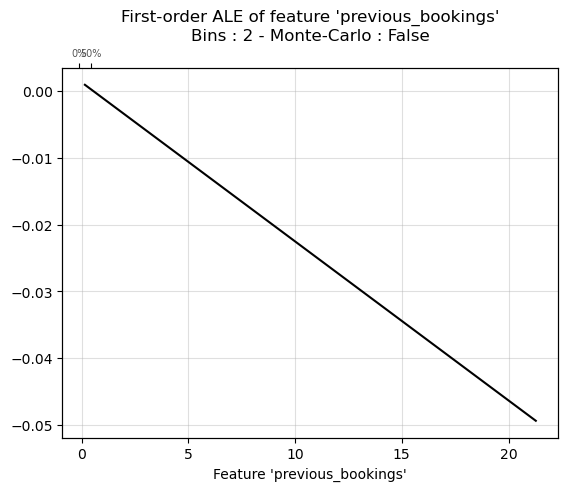

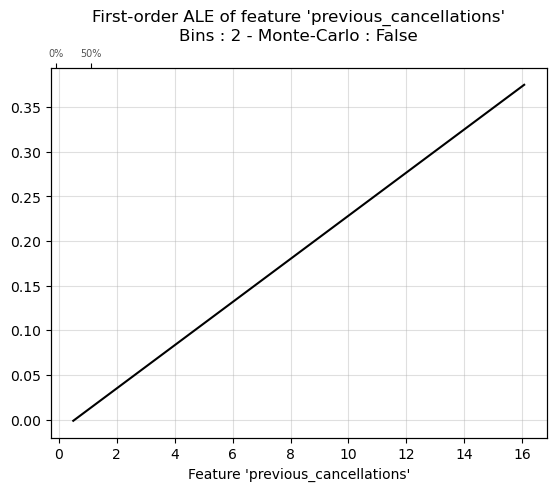

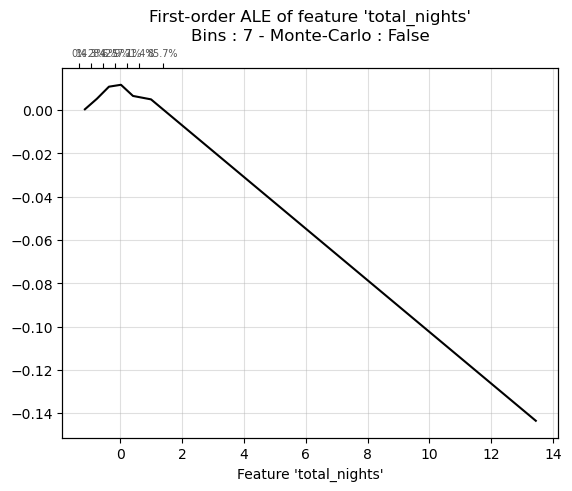

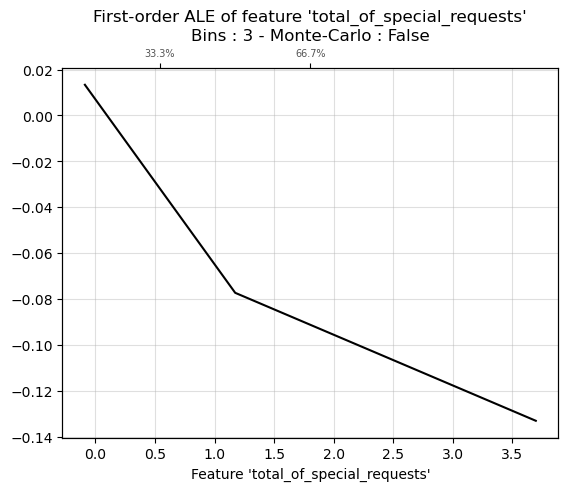

In [71]:
for col in num_cols:
    ale_plot(neigh, dftrain, col, bins=20)

## Second - Degree ALE Plots for Important Predictors

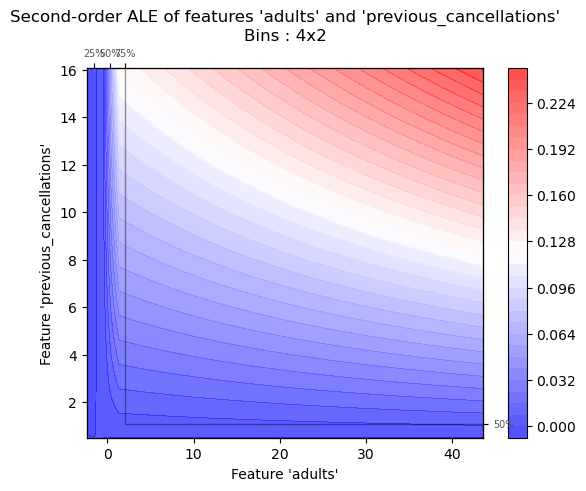

<AxesSubplot:title={'center':"Second-order ALE of features 'adults' and 'previous_cancellations'\nBins : 4x2"}, xlabel="Feature 'adults'", ylabel="Feature 'previous_cancellations'">

In [74]:
ale_plot(neigh, dftrain, ["adults", "previous_cancellations"], bins=20)

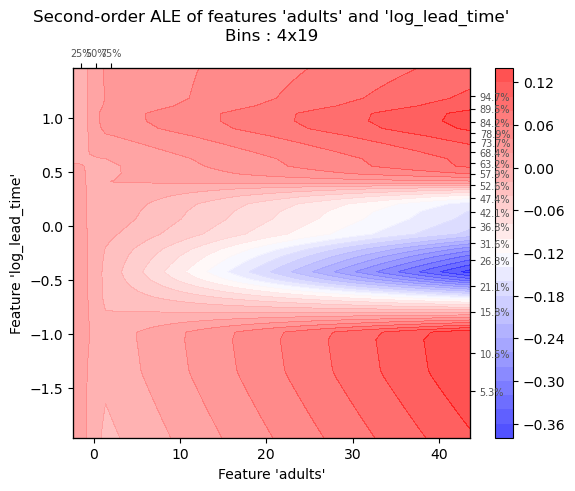

<AxesSubplot:title={'center':"Second-order ALE of features 'adults' and 'log_lead_time'\nBins : 4x19"}, xlabel="Feature 'adults'", ylabel="Feature 'log_lead_time'">

In [75]:
ale_plot(neigh, dftrain, ["adults", "log_lead_time"], bins=20)

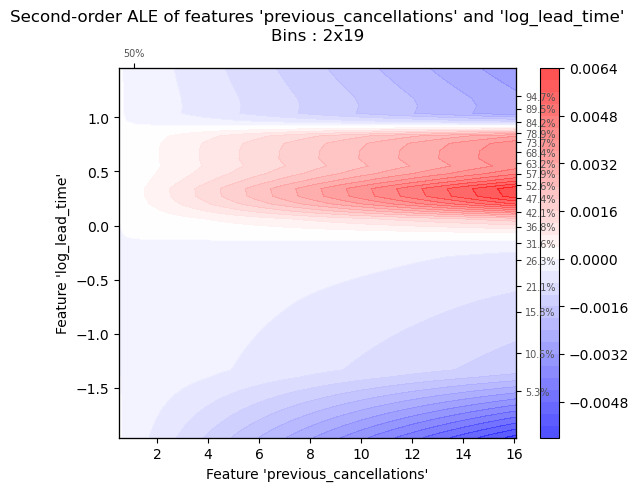

<AxesSubplot:title={'center':"Second-order ALE of features 'previous_cancellations' and 'log_lead_time'\nBins : 2x19"}, xlabel="Feature 'previous_cancellations'", ylabel="Feature 'log_lead_time'">

In [76]:
ale_plot(neigh, dftrain, ["previous_cancellations", "log_lead_time"], bins=20)